# Validus Risk Management Case Study

In [1]:
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy_financial as npf

# Monte Carlo Simulation for GBPHUF FX Spot Rate

The formula for Geometric Brownian Motion takes the following form:

$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t
$$

where:

- $ S_t $ is the asset price at time t  
- $ \mu $ is the drift 
- $ \sigma $ is the volatility 
- $ W_t $ is a Wiener process


We can apply Ito's Lemma to $ f(t,S) = ln(S) $ to get the dynamic of $ ln(S_t) $. This yields:

$$
S_t
=
S_0
\exp\!\left(
\left(\mu - \tfrac{1}{2}\sigma^2\right)(t - 0)
+ \sigma (W_t - W_0)
\right)
$$

For our simulation we must discretize time with a time step $ \delta t $. We also use properties of a Wiener process to get:

$$
S_{t+\delta t}
=
S_t \exp\!\left[
\left(\mu - \tfrac{1}{2}\sigma^2\right)\delta t
+ \sigma \epsilon \sqrt{\delta t}\, 
\right],
\quad \epsilon \sim \mathcal{N}(0,1)
$$

In [2]:
GBPHUF = 455.25 #start amount
sigma = 0.093   #this is the annual volatility 
mu = 0          #drift
nr = 1000       #number of simulations
T = 5           #time to maturity 
n = 5*252       #number of time steps

nu = mu - 0.5 * sigma**2
dt = 1/252

GBPHUF_val = np.zeros((nr,n+1))
epsilon = np.random.randn(nr,n)

GBPHUF_val[:,0] = GBPHUF
for i in range(nr): 
    for j in range(1,n+1): 
        GBPHUF_val[i,j] = GBPHUF_val[i,j-1] * m.exp(nu*dt + sigma * dt**0.5 * epsilon[i,j-1])

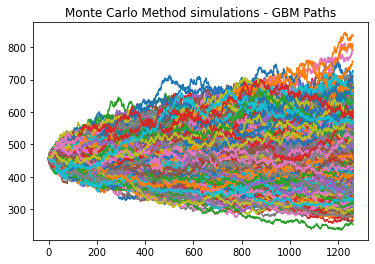

In [3]:
plt.figure()
for i in range(nr):
    plt.plot(GBPHUF_val[i,:])
plt.title('Monte Carlo Method simulations - GBM Paths');

## Question (a)

The GBPHUF FX Spot rate tells us the amount of HUF for 1 GBP. E.g. At t = 0, 455.25 HUF can be exchanged for 1 GBP. We can therefore convert HUF cashflows to GBP cashflows using the following:

$$
GBP_{CF} = \frac{HUF_{CF}}{S}
$$

$GBP_{CF}$ is our required cashflow in GBP, $HUF_{CF}$ is our cashflow in HUF and $S$ is our GBPHUF FX spot rate.

In order to do this calculation we will find the GBPHUF FX spot rate at the required time in our simulation and divide the HUF cashflows at that date by the rate. 

Then we calculate the IRR, which is a measure of an investments profatibility, in GBP terms using the formula below.

$$0 = \text{NPV} = \sum_{t=1}^{T} \frac{C_t}{(1 + \text{IRR})^t} - C_0$$

where:

- $ C_{\text{t}} $ is the net cash inflow during the period t 
- $ C_{\text{0}} $ is the total initial investment costs
- $ t $ is the number of time periods

In [4]:
data = pd.read_excel(r"C:\Users\roryx\Downloads\Junior_Quant_Case_Study_Aug_2025_-_Cashflow_Model.xlsx")

In [5]:
data

,Date,Fund,Cashflow Type,Cashflow Amount (in Local Asset Currecny),Local Asset Currency,Fund Currency,Base Case IRR
0,2025-08-01,Validus V,Equity,-100000000,HUF,GBP,0.149914
1,2026-08-01,Validus V,Proceeds,15000000,HUF,GBP,NaN
2,2027-08-01,Validus V,Proceeds,15000000,HUF,GBP,NaN
3,2028-08-01,Validus V,Proceeds,15000000,HUF,GBP,NaN
4,2029-08-01,Validus V,Proceeds,15000000,HUF,GBP,NaN
5,2030-08-01,Validus V,Proceeds,115000000,HUF,GBP,NaN


In [6]:
Years = []
for i in range(0,6):
    Years.append(i*252)
    print(f'Year {i} is after {i*252} Working Days')

Year 0 is after 0 Working Days
Year 1 is after 252 Working Days
Year 2 is after 504 Working Days
Year 3 is after 756 Working Days
Year 4 is after 1008 Working Days
Year 5 is after 1260 Working Days


In [7]:
Years

[0, 252, 504, 756, 1008, 1260]

In [8]:
GBPHUF_val_aug = GBPHUF_val[:, Years] #These are the simulated spot rate values as at the date of the cashflow

In [9]:
#Converting HUF Cashflows to GBP
GBP_CF = np.zeros_like(GBPHUF_val_aug)
for i in range(6):
    GBP_CF[:, i] = data.iloc[i,3]/GBPHUF_val_aug[:,i]

In [10]:
#IRR Calculation
irr = np.zeros(len(GBP_CF))
for i in range(len(GBP_CF)):
    irr[i] = npf.irr(GBP_CF[i,:])

In [11]:
#Finding the percentiles
p5, p50, p95 = np.percentile(irr, [5, 50, 95])

print(f"5th Percentile: {p5}")
print(f"50th Percentile: {p50}")
print(f"95th Percentile: {p95}")

5th Percentile: 0.0801791930909101
50th Percentile: 0.15337294857214168
95th Percentile: 0.2351120011761991


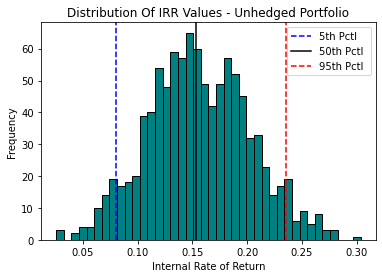

In [12]:
#Plotting the distribution
plt.hist(irr, bins=40, color='teal', edgecolor='black')
plt.axvline(p5, color='blue', linestyle='--', label='5th Pctl')
plt.axvline(p50, color='black', linestyle='-', label='50th Pctl')
plt.axvline(p95, color='red', linestyle='--', label='95th Pctl ')
plt.xlabel('Internal Rate of Return')
plt.ylabel('Frequency')
plt.title('Distribution Of IRR Values - Unhedged Portfolio')
plt.legend()
plt.show()

## Question (b)

The payoff for a European Put Option is as such 
$$
\text{Payoff} = \max(K - S_T,\, 0)
$$

This means the specified option will be in the money when the GBPHUF spot rate is less than the strike price of 455.25. Therefore we are protecting againt the HUF strenghtening vs the GBP.

For our GBPHUF option we will use the following formula:
$$
\text{Payoff}_{\text{HUF}} = N_{\text{GBP}} \max(K - S_T,\, 0)
$$

where:

- $ N_{\text{GBP}} $ is the nominal amount in GBP  
- $ K $ is the strike
- $ S_T $ is the GBPHUF Spot rate at 01/08/2029

We then convert the payoff into GBP by dividing the payoffs calculated above by the spot rate at that time. 

Then to get the price of the option we use the Fundamental Theorm of Asset pricing. $f(S_T)$ is the option payoff in GBP.

$$
f_0 = e^{-rT}\mathbb{E}^{\mathbb{Q}}[f(S_T)] \approx e^{-rT}\frac{1}{N}\sum_{i=1}^N f(S_T^{(i)})
$$

As the risk-free rates are 0%, Our discount factor ($e^{-rT}$) is 1. Therefore:

$$
Option Price = \mathbb{E}[Payoff_T]
$$

In [13]:
S_T = GBPHUF_val_aug[:,4]
K = 455.25
N_HUF = 100000000
N_GBP = N_HUF/K

FinPayOff_HUF = N_GBP * np.maximum(K-S_T, 0)            #N_GBP*np.maximum((K-S_T), 0)
FinPayOff_GBP = FinPayOff_HUF/S_T

price_gbp = FinPayOff_GBP.mean()

print(f"The price of our Put Option in GBP is: {price_gbp}")

The price of our Put Option in GBP is: 19065.094946892827


## Question (c)

The hedged portfolio cashflows consist of:

-The original fund cashflows <br>
-The option premium paid at t = 0 <br>
-The option payoff received at expiry (t = 4) <br>

The IRR will then be calculated similarly to above and the two portfolios will be compared

In [14]:
#New Cashflows of the Hedged Portfolio
H_GBP_CF = GBP_CF.copy()
H_GBP_CF[:,0] = GBP_CF[:,0] - price_gbp
H_GBP_CF[:,4] = GBP_CF[:,4] + FinPayOff_GBP 

In [15]:
#IRR Calculation
irr_hp = np.zeros(len(H_GBP_CF))
for i in range(len(H_GBP_CF)):
    irr_hp[i] = npf.irr(H_GBP_CF[i,:])

In [16]:
hp5, hp50, hp95 = np.percentile(irr_hp, [5, 50, 95])

print(f"5th Percentile of Hedged Portfolio: {hp5:.2f}. 5th Percentile of Unhedged Portfolio: {p5:.2f}.")
print(f"50th Percentile of Hedged Portfolio: {hp50:.2f}. 50th Percentile of Unhedged Portfolio: {p50:.2f}.")
print(f"95th Percentile of Hedged Portfolio: {hp95:.2f}. 95th Percentile of Unhedged Portfolio: {p95:.2f}.")

5th Percentile of Hedged Portfolio: 0.06. 5th Percentile of Unhedged Portfolio: 0.08.
50th Percentile of Hedged Portfolio: 0.13. 50th Percentile of Unhedged Portfolio: 0.15.
95th Percentile of Hedged Portfolio: 0.25. 95th Percentile of Unhedged Portfolio: 0.24.


In [17]:
std_dev_hp = np.std(irr_hp)
std_dev_p = np.std(irr)
print(f"The standard deviation of the Hedged Portfolio is: {std_dev_hp:.5f}")
print(f"The standard deviation of the Unhedged Portfolio is: {std_dev_p:.5f}")

The standard deviation of the Hedged Portfolio is: 0.05901
The standard deviation of the Unhedged Portfolio is: 0.04617


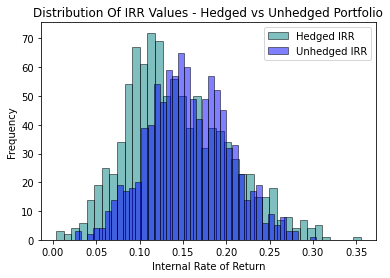

In [18]:
plt.hist(irr_hp, bins=40, color='teal',alpha=0.5, label='Hedged IRR', edgecolor='black')
plt.hist(irr, bins=40, color='blue',alpha=0.5, label='Unhedged IRR', edgecolor='black')
plt.xlabel('Internal Rate of Return')
plt.ylabel('Frequency')
plt.title('Distribution Of IRR Values - Hedged vs Unhedged Portfolio')
plt.legend()
plt.show()

We can see from these results that the choice of a European Put Option as a hedge is incorrect. It doesnt protect against a weakening HUF, which leads to a decrease in our GBP Cashflows. <br> 
It instead pays out when $S_t < K$ which means the HUF has strengthened and our cashflows have increased in GBP i.e. we are getting a payout in an already favourable situation. This is why the 95th percentile of the Hedged Portfolio is greater than that of the Unhedged Portfolio. <br> 
We also see the 5th percentile and 50th percentile of the Hedged Portfolio is lower than the Unhedged Portfolio due to the option price. This means that our Hedged Portfolio performs worse in adverse scenarios.<br> 
The standard deviation of the Hedged Portfolio is also higher, meaning IRR results are more volatile with the purchase of the Put option. These are not things we want from a hedge.

The correct hedging option would be a GBPHUF European Call. We will quickely compare the distributions below.

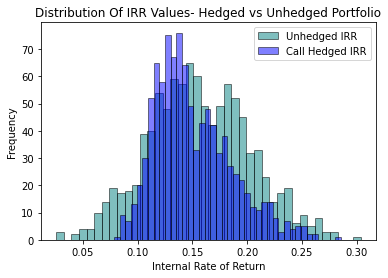

In [19]:
FinPayOffCall_HUF = N_GBP * np.maximum(S_T-K, 0)            
FinPayOffCall_GBP = FinPayOffCall_HUF/S_T

pricecall_gbp = FinPayOffCall_GBP.mean()

Call_GBP_CF = GBP_CF.copy()
Call_GBP_CF[:,0] = GBP_CF[:,0] - pricecall_gbp
Call_GBP_CF[:,4] = GBP_CF[:,4] + FinPayOffCall_GBP 

irr_call = np.zeros(len(Call_GBP_CF))
for i in range(len(Call_GBP_CF)):
    irr_call[i] = npf.irr(Call_GBP_CF[i,:])
    
plt.hist(irr, bins=40, color='teal',alpha=0.5, label='Unhedged IRR', edgecolor='black')
plt.hist(irr_call, bins=40, color='blue',alpha=0.5, label='Call Hedged IRR', edgecolor='black')
plt.xlabel('Internal Rate of Return')
plt.ylabel('Frequency')
plt.title('Distribution Of IRR Values- Hedged vs Unhedged Portfolio')
plt.legend()
plt.show()

We can see from the comparison of the distributions that we are much better protected against adverse scenarios with a GBPHUF Call option. This is because a Call Option pays out when $S_t > K$, which corresponds to a weakening HUF and a decrease in our projects cashflow in GBP.

We will also notice a lower standard deviation. This means our portfolio is less risky.

## Question (d)

This forward contract will allow us to exchange 115,000,000 HUF for GBP at a fixed rate of K = 455.25. Again as the risk-free rates are 0%, our discount factor is 1.

Mark-to-Market is the current market value of the forward contract.

We agree to Pay N HUF and receive $\frac{N}{K}$ GBP. At time t The market may give us $\frac{N}{S_t}$ GBP. The difference between these to values is the MTM:

$$
MTM_t^{GBP} = N (\frac{1}{S_t} - \frac{1}{K})
$$

A margin call is triggered whenever the absolute value of the MTM exceeds the GBP 70,000 threshold.

In [20]:
GBPHUF_val_2029 = GBPHUF_val[:, 0:1009]   
sim, time = GBPHUF_val_2029.shape
N = 115000000
threshold = 70000

margin_call = np.zeros(sim, dtype=bool)

for i in range(sim):
    for j in range(time):
        mtm = N * (1/GBPHUF_val_2029[i, j] - 1/K)
        if abs(mtm) > threshold:
            margin_call[i] = True 
            break

prob_margin_call = margin_call.mean()*100            

print(f"The probability of at least one margin call over the life of the trade is  {prob_margin_call:.2f}%")

The probability of at least one margin call over the life of the trade is  25.60%


### Notes

Approximate time spent: 6 hours. <br>
Use of AI: Latex syntax for formulas, Reference for MTM theory, Improving graphs, Introduction to numpy_financial IRR method.